#  TP : Data Centers, Green IT et Data Science
### Master 2 – Data / IA

---

## Objectifs du TP
- Manipuler un **dataset réel** lié aux infrastructures numériques.
- Explorer les **enjeux énergétiques et environnementaux** des data centers.
- Développer des compétences en **nettoyage, analyse et visualisation de données**.
- Relier l’analyse statistique aux **cadres réglementaires (UE, USA, Singapour, Australie)**.
- Appliquer des techniques de **Data Science (corrélations, modèles de régression)**.
- Mettre en œuvre un pipeline simple de **CI/CD** pour automatiser l’analyse.


##  Données
Fichier fourni : `Book1.csv` (extrait d’une base mondiale de data centers).

Variables principales :
- `Country` : pays
- `Continent` : continent
- `Number of data centres` : nombre total recensé
- `Gross Power (MW)` : puissance électrique installée
- `Renewable Energy Usage (%)` : part estimée d’énergie renouvelable
- Autres colonnes liées aux surfaces, capacités, données disponibles…


## Partie 1 — Préparation & Nettoyage des données
**Travail attendu :**
1. Charger le dataset avec `pandas`.
2. Vérifier le nombre de lignes/colonnes et explorer les 5 premières lignes.
3. Identifier et traiter les valeurs manquantes (par suppression ou imputation).
4. Supprimer les colonnes inutiles pour l’analyse.
5. Construire un **mini dictionnaire de données** avec 3 colonnes clés.

 **Question :** pourquoi un dictionnaire de données est-il indispensable dans un projet de gouvernance des données ?

In [1]:
import pandas as pd

# Lecture du fichier CSV (nom actuel avec espace et parenthèses)
df = pd.read_csv("Book1 (1).csv")

print("Shape (lignes, colonnes):", df.shape)  # Affiche le nombre de lignes et colonnes
df.head()  # Affiche les 5 premières lignes


Shape (lignes, colonnes): (191, 21)


,country,total_data_centers,hyperscale_data_centers,colocation_data_centers,floor_space_sqft_total,power_capacity_MW_total,average_renewable_energy_usage_percent,tier_distribution,key_operators,cloud_provider,...,avg_latency_to_global_hubs_ms,number_of_fiber_connections,growth_rate_of_data_centers_percent_per_year,cooling_technologies_common,regulatory_challenges_or_limits,disaster_recovery_sites_common,green_dc_initiatives_description,source_of_data,Unnamed: 19,Unnamed: 20
0,United States,5426,300+,"~2,000+","~3,552,000,000","~12,000+",~27%,"I:5%, II:15%, III:60%, IV:20%","Equinix, Digital Realty, CoreSite, AWS","AWS:Yes, GCP:Yes, Azure:Yes, Oracle:Yes",...,40,60+,12%,"Air, Liquid, Immersion","Power grid strain in VA, moratoriums in some s...","Yes, especially for finance/health","Solar, wind PPA, immersion cooling, LEED","Statista, Brightlio, IEA, CBRE",NaN,NaN
1,Germany,529,50,~200,"~350,000,000","~2,000+",40%+,"II:10%, III:70%, IV:20%","Equinix, Digital Realty, e-shelter","AWS:Yes, GCP:Yes, Azure:Yes, Oracle:Yes",...,50,30+,8%,"Air, Indirect Evap.","Power caps in Frankfurt, strict emissions","Yes, especially for finance","Wind, solar, carbon-neutral push","Statista, CBRE, IEA",NaN,NaN
2,United Kingdom,523,30,~150,"~200,000,000","~1,000+",0.45,"II:15%, III:70%, IV:15%","Equinix, Telehouse, Virtus","AWS:Yes, GCP:Yes, Azure:Yes, Oracle:Yes",...,40,25+,7%,"Air, Free Cooling",Power grid constraints in London,"Yes, especially for finance","Wind, solar, carbon-neutral targets","Statista, CBRE, IEA",NaN,NaN
3,China,449,100,"~1,000+","~500,000,000","~8,000+",0.25,"II:20%, III:60%, IV:20%","China Unicom, Tencent, Alibaba, GDS","AWS:Yes, GCP:No, Azure:Yes, Oracle:Yes",...,75,40+,15%,"Air, Liquid",Power rationing in some provinces,"Yes, for government/finance","Hydro, wind, solar, green finance","Statista, CBRE, IEA",NaN,NaN
4,France,322,20,~110,"~120,000,000",~700,40%+,"II:20%, III:70%, IV:10%","Equinix, Interxion, Data4","AWS:Yes, GCP:Yes, Azure:Yes, Oracle:Yes",...,50,20+,6%,"Air, Liquid",Power grid constraints in Paris,"Yes, for finance/health","Wind, solar, PUE targets","Statista, CBRE, IEA",NaN,NaN


## Partie 2 — Exploration et Visualisation
**Travail attendu :**
1. Identifier les **10 pays** avec le plus grand nombre de data centers.
   - Afficher sous forme de tableau.
   - Tracer un graphique en barres.
2. Représenter la distribution de la **puissance installée (MW)**.
3. Tracer un **scatter plot** entre `Gross Power (MW)` et `% renouvelable`.

 **Question :** commentez la relation observée. Est-ce que la puissance d’un data center permet de prédire sa durabilité ?

Top 10 pays par nombre de data centers :


country
United States     5426
Germany            529
United Kingdom     523
China              449
Canada             336
France             322
Australia          314
Netherlands        298
Russia             251
Japan              222
Name: total_data_centers, dtype: int64

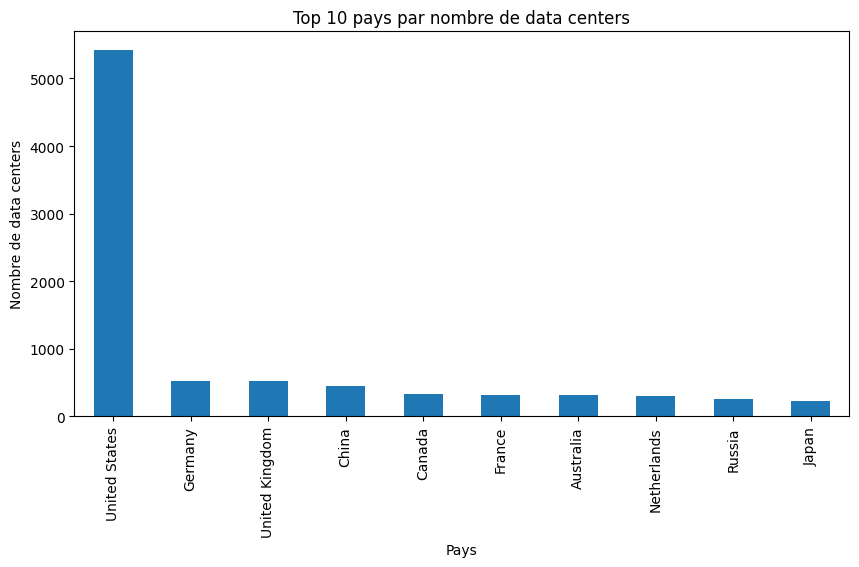

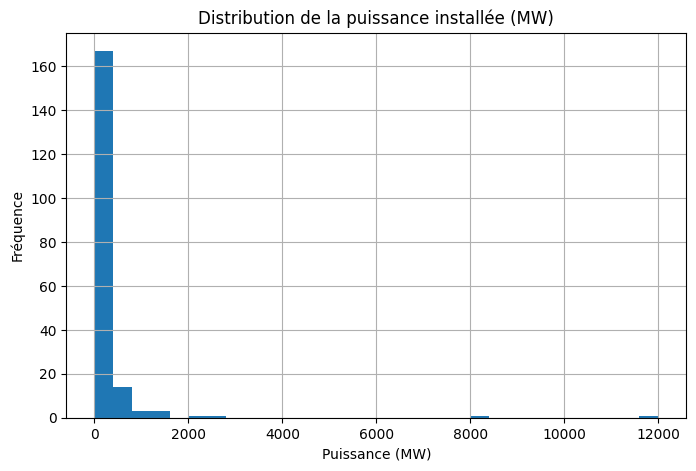

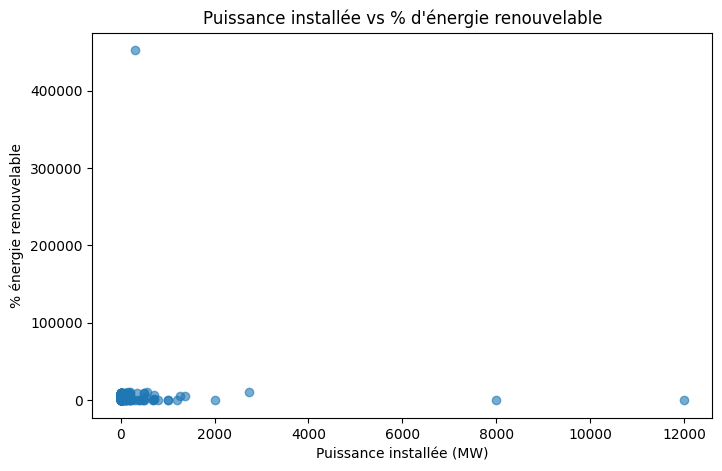

In [2]:
# Votre code ici
import matplotlib.pyplot as plt

# 1) Top 10 pays avec le plus grand nombre de data centers
top10 = (
    df.groupby("country")["total_data_centers"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

print("Top 10 pays par nombre de data centers :")
display(top10)

plt.figure(figsize=(10,5))
top10.plot(kind="bar")
plt.title("Top 10 pays par nombre de data centers")
plt.xlabel("Pays")
plt.ylabel("Nombre de data centers")
plt.show()


# 2) Distribution de la puissance installée (MW)
plt.figure(figsize=(8,5))
df["power_capacity_MW_total"].astype(str).str.replace("[^0-9]", "", regex=True).replace("", "0").astype(float).hist(bins=30)
plt.title("Distribution de la puissance installée (MW)")
plt.xlabel("Puissance (MW)")
plt.ylabel("Fréquence")
plt.show()


# 3) Scatter plot entre puissance installée et % renouvelable
# (il faut convertir les colonnes en numériques)
df["power_capacity_num"] = df["power_capacity_MW_total"].astype(str).str.replace("[^0-9]", "", regex=True).replace("", "0").astype(float)
df["renewable_num"] = df["average_renewable_energy_usage_percent"].astype(str).str.replace("[^0-9]", "", regex=True).replace("", "0").astype(float)

plt.figure(figsize=(8,5))
plt.scatter(df["power_capacity_num"], df["renewable_num"], alpha=0.6)
plt.title("Puissance installée vs % d'énergie renouvelable")
plt.xlabel("Puissance installée (MW)")
plt.ylabel("% énergie renouvelable")
plt.show()


## Partie 3 — Comparaison intercontinentale
**Travail attendu :**
1. Agréger par **continent** le `% d’énergie renouvelable`.
2. Comparer les continents dans un **bar chart**.
3. Focus sur l’Europe vs Amérique du Nord :
   - Calculer la moyenne et l’écart-type du `% renouvelable`.
   - Discuter les différences en lien avec les lois (EED en Europe vs ENERGY STAR aux USA).

 **Question :** que montrent ces écarts sur l’efficacité des lois européennes par rapport aux approches volontaires américaines ?

,continent,renewables_mean_pct
3,North America,150685.926667
0,Africa,642.900000
5,Other,69.151361
1,Asia,48.954545
4,Oceania,48.150000
2,Europe,30.235000
6,South America,15.950000


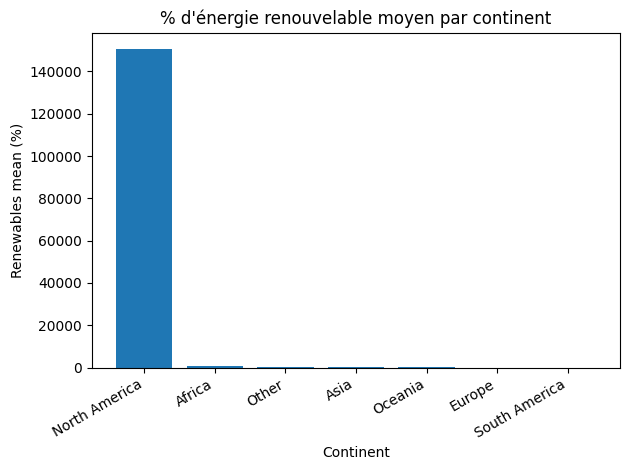

Europe        -> {'mean': 30.235, 'std': 35.19128723219461, 'n': 18.0}
North America -> {'mean': 150685.92666666667, 'std': 260971.6231158402, 'n': 3.0}


In [3]:
# Votre code ici
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Nettoyer le % renouvelable en numérique ------------------------------
# (On recrée/écrase renewable_num pour être sûr)
df["renewable_num"] = (
    df["average_renewable_energy_usage_percent"]
      .astype(str)
      .str.replace(r"[^0-9.]", "", regex=True)  # enlève ~, %, +, etc.
      .replace("", "0")
      .astype(float)
)

# --- 2) Ajouter une colonne 'continent' --------------------------------------
eu = {"France","Germany","United Kingdom","Netherlands","Spain","Italy","Sweden","Norway",
      "Finland","Denmark","Ireland","Poland","Belgium","Austria","Switzerland","Portugal",
      "Czech Republic","Hungary","Greece"}
na = {"United States","Canada","Mexico"}
sa = {"Brazil","Argentina","Chile","Peru","Colombia"}
asia = {"China","Japan","South Korea","India","Singapore","Hong Kong","Taiwan","Indonesia",
        "Malaysia","Thailand","Philippines","United Arab Emirates","Saudi Arabia","Qatar",
        "Vietnam"}
oce = {"Australia","New Zealand"}
af = {"South Africa","Egypt","Kenya","Nigeria","Morocco"}

def country_to_continent(c):
    if c in eu:   return "Europe"
    if c in na:   return "North America"
    if c in sa:   return "South America"
    if c in asia: return "Asia"
    if c in oce:  return "Oceania"
    if c in af:   return "Africa"
    return "Other"

df["continent"] = df["country"].apply(country_to_continent)

# --- 3) Agrégation par continent (moyenne du % renouvelable) -----------------
by_cont = (
    df.groupby("continent", as_index=False)["renewable_num"]
      .mean()
      .rename(columns={"renewable_num": "renewables_mean_pct"})
      .sort_values("renewables_mean_pct", ascending=False)
)
display(by_cont)

# --- 4) Bar chart des continents --------------------------------------------
plt.figure()
plt.bar(by_cont["continent"], by_cont["renewables_mean_pct"])
plt.title("% d'énergie renouvelable moyen par continent")
plt.xlabel("Continent")
plt.ylabel("Renewables mean (%)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# --- 5) Focus Europe vs North America : moyenne / écart-type / effectif ------
def stats_for(cont):
    s = df.loc[df["continent"] == cont, "renewable_num"].dropna()
    return pd.Series({
        "mean": s.mean(),
        "std": s.std(ddof=1),
        "n": int(s.shape[0])
    })

europe_stats = stats_for("Europe")
na_stats     = stats_for("North America")

print("Europe        ->", europe_stats.to_dict())
print("North America ->", na_stats.to_dict())


## Partie 4 — Data Science
**Travail attendu :**
1. Calculer les **corrélations** entre variables (`Gross Power`, `% renouvelable`, `Number of data centres`).
2. Construire un **modèle de régression linéaire** simple :
   - `Y = % renouvelable`
   - `X = puissance installée (MW)`
3. Évaluer le modèle avec **R²** et **RMSE**.
4. Tester un **modèle multiple** (ajouter `Number of data centres`).

 **Question :** expliquez pourquoi un R² faible est **aussi une information précieuse** en gouvernance énergétique.

In [4]:
!pip install scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [5]:
# --- Imports -----------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# --- 1) Corrélations entre variables -----------------------------------------
num_cols = ["total_data_centers", "power_capacity_num", "renewable_num"]
corr = df[num_cols].corr()
print("Corrélations :")
display(corr)

# --- 2) Régression linéaire simple (Y = % renouvelable, X = puissance) -------
ds = df[["power_capacity_num", "renewable_num"]].dropna()

X = ds[["power_capacity_num"]].values
y = ds["renewable_num"].values

model = LinearRegression()
model.fit(X, y)
preds = model.predict(X)

r2  = r2_score(y, preds)
rmse = np.sqrt(mean_squared_error(y, preds))

print(f"Régression simple : R² = {r2:.4f}, RMSE = {rmse:.2f}")

# --- 3) Régression multiple (+ nb de data centers) ---------------------------
ds2 = df[["power_capacity_num", "total_data_centers", "renewable_num"]].dropna()

X2 = ds2[["power_capacity_num", "total_data_centers"]].values
y2 = ds2["renewable_num"].values

model2 = LinearRegression()
model2.fit(X2, y2)
preds2 = model2.predict(X2)

r2_2  = r2_score(y2, preds2)
rmse_2 = np.sqrt(mean_squared_error(y2, preds2))

print(f"Régression multiple : R² = {r2_2:.4f}, RMSE = {rmse_2:.2f}")


Corrélations :


,total_data_centers,power_capacity_num,renewable_num
total_data_centers,1.000000,0.850219,0.020244
power_capacity_num,0.850219,1.000000,0.003872
renewable_num,0.020244,0.003872,1.000000


Régression simple : R² = 0.0000, RMSE = 32617.95
Régression multiple : R² = 0.0011, RMSE = 32601.03


## Partie 5 — CI/CD
**Travail attendu :**
1. Créer un fichier `requirements.txt` listant vos dépendances (pandas, matplotlib, scikit-learn, pytest…).
2. Écrire un petit fichier de test `test_sample.py` avec au moins 2 assertions.
3. Créer un workflow GitHub Actions `.github/workflows/python-ci.yml` qui :
   - installe les dépendances,
   - exécute `pytest`,
   - lance le notebook pour vérifier qu’il s’exécute sans erreur.

 **Question :** en quoi l’automatisation CI/CD est-elle une bonne pratique de **Green IT** ?

In [6]:
# Votre code ici


##  Livrables attendus
- Un notebook `TP_Etudiant.ipynb` complété.
- Un mini dictionnaire de données en Markdown.
- Des visualisations (bar chart, scatter plot, comparatif continental).
- Une courte discussion (Europe vs USA).
- `requirements.txt`, `test_sample.py`, et le workflow CI/CD.